In [1]:
import pandas as pd
import numpy as np
import ReST
import scipy as sp
import scanpy as sc
from anndata import AnnData as ad

In [2]:
def createReSTobject(ho_fn):
    ho_df = pd.read_csv(ho_fn, index_col=0)
    acs, ars = [int(i.split("x")[0]) for i in ho_df.index],  [int(i.split("x")[1]) for i in ho_df.index]
    obs_df = pd.DataFrame({'array_col': acs, 'array_row': ars}, index=ho_df.index)
    var_df = pd.DataFrame({'gene': ho_df.columns}, index=ho_df.columns)
    ho_rd = ReST.ReST(counts=ho_df, coordinates=obs_df, gene_df=var_df)
    return ho_rd

In [3]:
def preprocess(adata0, hvg_prop=0.8, n_pcs=30):
    adata = adata0.copy()
    sc.pp.filter_genes(adata0, min_cells=10)
    adata.var_names_make_unique()
    adata.obs['new_idx'] = adata.obs[['array_col', 'array_row']].apply(lambda x: 'x'.join(x.astype(str)), axis=1)
    ## Data normalization 
    # LOG2CPM normalization
    sc.pp.normalize_total(adata, inplace=True, target_sum=10**6)
    sc.pp.log1p(adata, base=2)
    sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=int(hvg_prop * adata.shape[1]))
    ## Construct a knn graph based on PC similarity (top 50, nneighbors=100)
    sc.pp.pca(adata, n_comps=n_pcs)
    adata.obsp['raw_weights'] = pd.DataFrame(data=adata.obsm['X_pca'], 
        index=adata.obs_names).T.corr().loc[adata.obs_names, adata.obs_names].values
    return adata

In [4]:
# ho_rd.adata.obsp['raw_weights']

 12%|█▏        | 2/17 [00:00<00:00, 15.60it/s]

MIST Data created in 1.35 seconds.


100%|██████████| 17/17 [00:05<00:00,  2.92it/s]


Epsilon 0.550 is selected in 6.26 seconds.


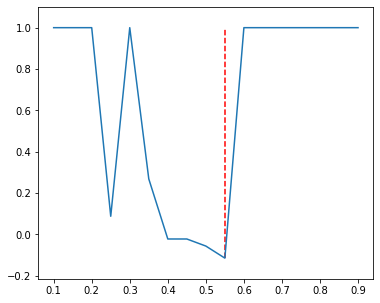

In [12]:
ho_fn = '../data/Prostate/ho_data_3.csv'
ho_rd = createReSTobject(ho_fn)

raw_fn = '../data/Prostate/raw.csv'
raw_data = createReSTobject(raw_fn)
raw_data.adata = preprocess(raw_data.adata)

if raw_data.shape[0] < 1000:
    min_region = 10
else:
    min_region = 40
    
raw_data.extract_regions(min_sim=0.1, min_region = min_region)
ho_rd.adata.obs['region_ind'] = raw_data.adata.obs.loc[ho_rd.adata.obs.index, 'region_ind']

<AxesSubplot:xlabel='array_row', ylabel='array_col'>

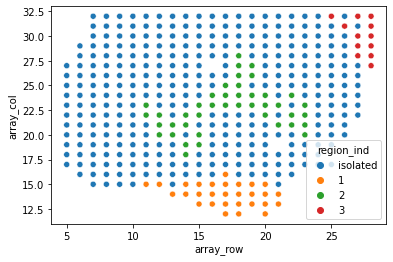

In [13]:
import seaborn as sns

sns.scatterplot(data=raw_data.adata.obs, y='array_col', x='array_row', hue='region_ind')

In [9]:
raw_data.adata.obs

,array_col,array_row,new_idx,region_ind
15x10,15,10,15x10,isolated
16x10,16,10,16x10,isolated
17x10,17,10,17x10,isolated
18x10,18,10,18x10,isolated
19x10,19,10,19x10,isolated
...,...,...,...,...
28x9,28,9,28x9,isolated
29x9,29,9,29x9,isolated
30x9,30,9,30x9,isolated
31x9,31,9,31x9,isolated


In [21]:
raw_data.shape

(406, 17678)

In [11]:
import MIST2
import importlib
importlib.reload(MIST2)
MIST2.MIST(ho_rd, 4, 4, 1) 

[Start][Region] 0 / 3 | [Spots] 374 / 789.
[0 / 0] imputation started with 1193 observations and 4818 varaibles.
[0 / 1] imputation started with 1193 observations and 4818 varaibles.
[0 / 2] imputation started with 1192 observations and 4818 varaibles.
[0 / 3] imputation started with 1191 observations and 4818 varaibles.


Process ForkPoolWorker-5:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/houston_20t/alexw/ST/MIST_additional_holdout/scripts/MIST2.py", line 136, in rankMinImpute
    U, S, V = np.linalg.svd(B,full_matrices=False)


KeyboardInterrupt: 

  File "<__array_function__ internals>", line 6, in svd
  File "/home/alexw/.local/lib/python3.6/site-packages/numpy/linalg/linalg.py", line 1661, in svd
    u, s, vh = gufunc(a, signature=signature, extobj=extobj)
KeyboardInterrupt
Process ForkPoolWorker-7:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/houston_20t/alexw/ST/MIST_additional_holdout/scripts/MIST2.py", line 136, in rankMinImpute
    U, S, V = np.linalg.svd(B,full_matrices=False)
  File "<__array_function__ internals>", line 6, in svd
  File "/home/alexw/.local/lib/python3.6/site-packages/numpy/linalg/lin

In [15]:
import sys
print(sys.getrecursionlimit())

10000
